In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, models, InputExample, losses
from sentence_transformers import evaluation
import numpy as np
from sklearn.metrics import confusion_matrix
import math
import numpy as np

model_id = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_id)

In [3]:
print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)


In [4]:
dev_dp = 'SemEval-PIT2015-github/data/dev.data'
train_dp = 'SemEval-PIT2015-github/data/train.data'
test_dp = 'SemEval-PIT2015-github/data/test.data'

In [5]:
def get_gt_label(x):
    if int(x) in [0,1,2]:
        return 0.0
    elif int(x) in [4,5]:
        return 1.0
    else:
        return -1.0
    
def get_pred_label(x, thresh=0.5):
    return 1.0 if x>=thresh else 0.0

def get_gt_train_label(x):
    if int(x[0])==2 and int(x[1])==3:
        return -1.0
    elif int(x[0])>=int(x[1]):
        return 1.0
    else:
        return 0.0

In [6]:
# create train, val and test sets
from tqdm import tqdm 
train_examples = []
train_gt = []
with open(train_dp, 'r') as f:
    lines = f.readlines() #[choose:choose+1]
    sent1_train, sent2_train = [], []
    for line in tqdm(lines, total=len(lines)):
        comp = line.split('\t')
        gt = get_gt_train_label(comp[4][1:-1].split(','))
        # to skip ambiguous cases..
        if gt == -1:
            continue
        sent1_train.append(comp[2])
        sent2_train.append(comp[3])
        # label=torch.tensor(gt).long()
        train_examples.append(InputExample(texts=[comp[2], comp[3]], label=gt))
        # print(comp[2], "\t", comp[3], gt)
        train_gt.append(gt)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13063/13063 [00:00<00:00, 155783.63it/s]


[Text(0.5, 1.0, 'Frequency Histogram of train_labels'),
 Text(0, 0.5, 'Frequency')]

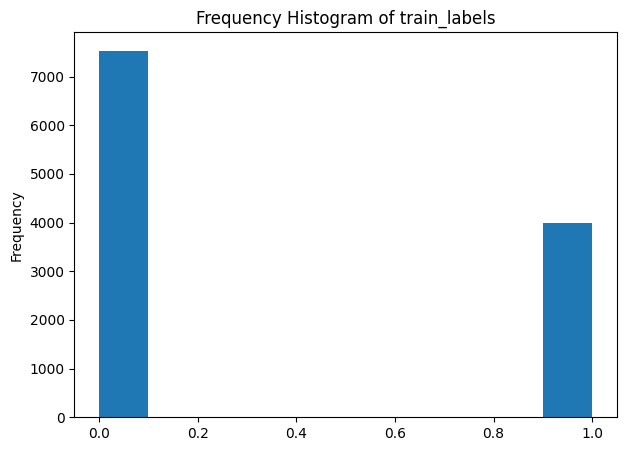

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = np.array(train_gt)
plt.hist(x, bins=10)
plt.gca().set(title='Frequency Histogram of train_labels', ylabel='Frequency')

In [57]:
dev_examples = []
with open(dev_dp, 'r') as f:
    lines = f.readlines() #[choose:choose+1]
    sent1_val, sent2_val, val_gt = [], [], []
    for line in tqdm(lines, total=len(lines)):
        comp = line.split('\t')
        gt = get_gt_train_label(comp[4][1:-1].split(','))
        # to skip ambiguous cases..
        if gt == -1:
            continue
        sent1_val.append(comp[2])
        sent2_val.append(comp[3])
        val_gt.append(gt)
        # torch.tensor(gt).long()
        dev_examples.append(InputExample(texts=[comp[2], comp[3]], label=gt))
        
dev_dataloader = DataLoader(dev_examples, shuffle=True, batch_size=16)
evaluator = evaluation.EmbeddingSimilarityEvaluator(sent1_val, sent2_val, val_gt)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4727/4727 [00:00<00:00, 175257.01it/s]


In [10]:
train_loss = losses.CosineSimilarityLoss(model)
# train_loss = losses.SoftmaxLoss(model=model,
#                                 sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
#                                 num_labels=2)

In [11]:
# ... Your other code to load training data
#  evaluator=evaluator,
epochs=2
warmup_steps = int(len(train_dataloader) * epochs * 0.1)
output_path = f'./output_base_{epochs}epoch_wdyn{warmup_steps}_cosine'
print('Epochs: ',epochs, 'Warmup Steps: ',warmup_steps)

model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=epochs, evaluator=evaluator, warmup_steps=warmup_steps, evaluation_steps=100, output_path=output_path)

Epochs:  2 Warmup Steps:  144


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/721 [00:00<?, ?it/s]

Iteration:   0%|          | 0/721 [00:00<?, ?it/s]

In [58]:
# using sentence transformer models for inference
class SentenceTransformerModel:
    def __init__(self, model_name, device='cuda'):
        self.model_name = model_name
        self.device = device
        self.model = self.get_transformer()
        
    def get_transformer(self):
        model = SentenceTransformer(self.model_name, device=self.device)
        return model
    
    def get_batched_data(self, iterable, bs=1):
        len_iter = len(iterable)
        for idx in range(0, len_iter, bs):
            yield iterable[idx:min(idx + bs, len_iter)]

    def get_encodings(self, data, bs = 64):
        # computes bs embeddings and returns stacked output
        model_out = self.model.encode(data,
                                     batch_size=bs,
                                     show_progress_bar=True,
                                     device=self.device,
                                     convert_to_tensor=True)
        return model_out
    

def compute_precision(y_true, y_pred, pos_class=True):
    true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, y_pred).ravel()
    precision = 0.0
    if pos_class:
        if true_pos+false_pos != 0:
            precision = true_pos/(true_pos+false_pos)
    else:
        if true_neg+false_neg != 0:
            precision = true_neg/(true_neg+false_neg)
    return precision

def compute_recall(y_true, y_pred, pos_class=True):
    true_neg, false_pos, false_neg, true_pos = confusion_matrix(y_true, y_pred).ravel()
    recall = 0.0
    if pos_class:
        if true_pos+false_neg != 0:
            recall = true_pos/(true_pos+false_neg)
    else:
        if true_neg+false_pos!=0:
            recall = true_neg/(true_neg+false_pos)
    return recall

def compute_fscore(y_true, y_pred, pos_class = True, beta=1):
    precision = compute_precision(y_true, y_pred, pos_class)
    recall = compute_recall(y_true, y_pred, pos_class)
    fscore = 0.0
    if precision+recall!=0:
        fscore = (1+math.pow(beta,2))*(precision*recall)/(math.pow(beta,2)*precision + recall)
    return fscore

In [44]:
from sentence_transformers import SentenceTransformer, models, InputExample
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer, InputExample, losses
from sentence_transformers import evaluation
# Testing the model
model_b0 = SentenceTransformerModel(model_name="all-MiniLM-L6-v2")
model_b1 = SentenceTransformer(output_path)

In [45]:
# preparing data points
all_gts = []

with open(test_dp, 'r') as f:
    lines = f.readlines() #[choose:choose+1]
    sent1_data, sent2_data = [], []
    for line in tqdm(lines, total=len(lines)):
        comp = line.split('\t')
        gt = get_gt_label(comp[4])
        if gt == -1:
            continue
        sent1_data.append(comp[2])
        sent2_data.append(comp[3])
        all_gts.append(gt)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 972/972 [00:00<00:00, 487313.35it/s]


In [46]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

# Test data

In [126]:
import torch
cos = torch.nn.CosineSimilarity(dim=1)

# model b0
model_b0_out1 = model_b0.get_encodings(sent1_data)
model_b0_out2 = model_b0.get_encodings(sent2_data)
# print(type(model_out1),model_out1.shape, model_out2.shape)

model_b1_out1 = torch.from_numpy(model_b1.encode(sent1_data))
model_b1_out2 = torch.from_numpy(model_b1.encode(sent2_data))

sim_b0 = cos(model_b0_out1, model_b0_out2)
sim_b1 = cos(model_b1_out1, model_b1_out2)

# sim = torch.sub(model_out1, model_out2)
print(sim_b0.shape)
print(sim_b1.shape)

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

torch.Size([838])
torch.Size([838])


In [127]:
sim_b0 = sim_b0.to('cpu').numpy()
sim_b1 = sim_b1.to('cpu').numpy()
# print(sim)
sim_pred_b0 = [get_pred_label(x, thresh=0.45) for x in sim_b0]
sim_pred_b1 = [get_pred_label(x, thresh=0.45) for x in sim_b1]


# Error Analysis

In [164]:
def errors_ind(arr, arr1):
    diff  = np.array(arr) - arr1
    error_ind = np.where((diff==1)|(diff==-1))[0]
    return error_ind
def corr_ind(arr, arr1):
    diff = np.array(arr) - arr1
    corr_ind = np.where((diff==0))[0]
    return corr_ind

In [170]:
e_i = errors_ind(sim_pred_b0,all_gts)
e_c = corr_ind(sim_pred_b1,all_gts)
des = np.intersect1d(e_i, e_c)

error_sent1 = [sent1_data[ind] for ind in des]
error_sent2 = [sent2_data[ind] for ind in des]
lab_b1 = [sim_pred_b1[ind] for ind in des]
lab_b0 = [sim_pred_b0[ind] for ind in des]
lab_gt = [all_gts[ind] for ind in des]

In [174]:
for x, y, z, m, n in zip(error_sent1, error_sent2, lab_b0, lab_b1, lab_gt):
    # print(x, '\t', y, '\t', z)
    print(x, '\t', y, '####', z,',',m,',', n)

All the home alones watching 8 mile 	 The rap battle at the end of 8 mile gets me so hype #### 1.0 , 0.0 , 0.0
The Ending to 8 Mile is my fav part of the whole movie 	 See 8 Mile is always on but it s the tv version so it s gay #### 1.0 , 0.0 , 0.0
0 and 8 mile on at the same time 	 It s just rap lyrics from the movie 8 mile #### 1.0 , 0.0 , 0.0
0 and 8 mile on at the same time 	 I will never get tired of 8 Mile #### 1.0 , 0.0 , 0.0
The last rap battle in 8 mile though 	 I think everyone is watching 8 mile Rn #### 1.0 , 0.0 , 0.0
Well at least 8 Mile is on 	 8 mile has been that movie #### 1.0 , 0.0 , 0.0
Well at least 8 Mile is on 	 I really did miss my part on 8 Mile #### 1.0 , 0.0 , 0.0
Well at least 8 Mile is on 	 Lose Yourself is the perfect song to end 8 mile on #### 1.0 , 0.0 , 0.0
8 mile is on friday made 	 I missed the best part of 8 mile #### 1.0 , 0.0 , 0.0
Oh shit niggy 8 mile is on 	 Eminem s rap in the final battle of 8 Mile gets me pumped every time #### 1.0 , 0.0 , 0.0


In [175]:
# errors of finetuned model
des = errors_ind(sim_pred_b1,all_gts)

error_sent1 = [sent1_data[ind] for ind in des]
error_sent2 = [sent2_data[ind] for ind in des]
lab_b1 = [sim_pred_b1[ind] for ind in des]
lab_b0 = [sim_pred_b0[ind] for ind in des]
lab_gt = [all_gts[ind] for ind in des]

for x, y, z, m, n in zip(error_sent1, error_sent2, lab_b0, lab_b1, lab_gt):
    # print(x, '\t', y, '\t', z)
    print(x, '\t', y, '####', z,',',m,',', n)

8 mile is on friday made 	 8 mile is such an awesome movie #### 1.0 , 1.0 , 0.0
Oh shit niggy 8 mile is on 	 While yall argue about the game 8 mile is on MTV #### 1.0 , 0.0 , 1.0
Ok good the end of 8 Mile is on 	 The last 3 rap battles in 8 mile always get me hyped af #### 1.0 , 0.0 , 1.0
Anyone trying to see After Earth sometime soon 	 Me and my son went to see After Earth last night #### 1.0 , 1.0 , 0.0
i need to watch after earth asap 	 At the theater with the little about do watch After Earth #### 1.0 , 1.0 , 0.0
i need to watch after earth asap 	 Someone needs to come see after earth with me #### 1.0 , 0.0 , 1.0
I love everyone on the Belgium squad 	 In other news this Belgium squad taking on USMNT is STACKED #### 1.0 , 0.0 , 1.0
congratulations to petr ech and rafa benitez 	 Credit where credits due to Rafa Benitez #### 1.0 , 0.0 , 1.0
THANK YOU SO MUCH RAFA BENITEZ 	 Credit where credits due to Rafa Benitez #### 1.0 , 0.0 , 1.0
Mario Chalmers pissin me off 	 Mario Chalmers needs

In [120]:
a,b = all_gts, sim_pred_b0
print(f'precision: {compute_precision(a, b)}, recall: {compute_recall(a, b)}, f1: {compute_fscore(a, b)}')

precision: 0.3022847100175747, recall: 0.9828571428571429, f1: 0.4623655913978494


In [121]:
a,b = all_gts, sim_pred_b0
print(f'precision: {compute_precision(a, b, pos_class=False)}, recall: {compute_recall(a, b, pos_class=False)}, f1: {compute_fscore(a, b, pos_class=False)}')

precision: 0.9888475836431226, recall: 0.40120663650075417, f1: 0.5708154506437768


In [122]:
a,b = all_gts, sim_pred_b1
print(f'precision: {compute_precision(a, b)}, recall: {compute_recall(a, b)}, f1: {compute_fscore(a, b)}')

precision: 0.8278688524590164, recall: 0.5771428571428572, f1: 0.68013468013468


In [123]:
a,b = all_gts, sim_pred_b1
print(f'precision: {compute_precision(a, b, pos_class=False)}, recall: {compute_recall(a, b, pos_class=False)}, f1: {compute_fscore(a, b, pos_class=False)}')

precision: 0.8966480446927374, recall: 0.9683257918552036, f1: 0.9311094996374184


# Eval Data

In [94]:
import torch
cos = torch.nn.CosineSimilarity(dim=1)

# model b0
model_b0_out1 = model_b0.get_encodings(sent1_val)
model_b0_out2 = model_b0.get_encodings(sent2_val)
# print(type(model_out1),model_out1.shape, model_out2.shape)

model_b1_out1 = torch.from_numpy(model_b1.encode(sent1_val))
model_b1_out2 = torch.from_numpy(model_b1.encode(sent2_val))

sim_b0 = cos(model_b0_out1, model_b0_out2)
sim_b1 = cos(model_b1_out1, model_b1_out2)

# sim = torch.sub(model_out1, model_out2)
print(sim_b0.shape)
print(sim_b1.shape)

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

torch.Size([4142])
torch.Size([4142])


In [95]:
sim_b0 = sim_b0.to('cpu').numpy()
sim_b1 = sim_b1.to('cpu').numpy()
# print(sim)
sim_pred_b0 = [get_pred_label(x, thresh=0.45) for x in sim_b0]
sim_pred_b1 = [get_pred_label(x, thresh=0.45) for x in sim_b1]

In [96]:
a,b = val_gt, sim_pred_b0
print(f'precision: {compute_precision(a, b)}, recall: {compute_recall(a, b)}, f1: {compute_fscore(a, b)}')

precision: 0.4167636786961583, recall: 0.9741496598639455, f1: 0.5837749694251937


In [97]:
a,b = val_gt, sim_pred_b0
print(f'precision: {compute_precision(a, b, pos_class=False)}, recall: {compute_recall(a, b, pos_class=False)}, f1: {compute_fscore(a, b, pos_class=False)}')

precision: 0.9461756373937678, recall: 0.25, f1: 0.39550029603315573


In [98]:
a,b = val_gt, sim_pred_b1
print(f'precision: {compute_precision(a, b)}, recall: {compute_recall(a, b)}, f1: {compute_fscore(a, b)}')

precision: 0.8023833167825224, recall: 0.5496598639455782, f1: 0.6524020993136859


In [99]:
a,b = val_gt, sim_pred_b1
print(f'precision: {compute_precision(a, b, pos_class=False)}, recall: {compute_recall(a, b, pos_class=False)}, f1: {compute_fscore(a, b, pos_class=False)}')

precision: 0.7888357256778309, recall: 0.9255239520958084, f1: 0.8517306698811778
